In [1]:
import os
import shap
import joblib
import datetime
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from minepy import MINE
from functools import reduce
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from statistics import StatisticsError
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, LabelEncoder

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

c:\Users\Shrikanth Singh\anaconda3\envs\fressnapf_task\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
customer_segment_data = pd.read_csv(os.path.join('data', 'customer_segmentation_data.csv'), 
                                    index_col=[0])

### Feature Engineering


#### Number of Transactions per Customer

In [3]:
num_transaction = customer_segment_data.copy()
num_transaction = num_transaction.groupby(['Customer_ID'])\
                       .agg(n_transactions=('Purchase_Date', 'count')).reset_index()
num_transaction.tail()

,Customer_ID,n_transactions
99991,1999884363,11
99992,1999900682,7
99993,1999914177,13
99994,1999935464,17
99995,1999975156,15


#### Transaction per Customer

In [4]:
feature_transaction = customer_segment_data.copy()

feature_transaction['Total_transaction'] = feature_transaction['Quantity'] * \
                                           feature_transaction['Unit_Cost']

transaction_per_cust = feature_transaction.groupby(['Customer_ID'])\
                       .agg(Transaction_per_custID=('Total_transaction', 'sum')).reset_index()

transaction_per_cust.tail()

,Customer_ID,Transaction_per_custID
99991,1999884363,849.84
99992,1999900682,499.13
99993,1999914177,1061.76
99994,1999935464,1229.23
99995,1999975156,1224.72


#### Transaction per Customer per Channel

In [5]:
transaction_per_cust_per_channel = feature_transaction.groupby(['Customer_ID', 'Purchase_Channel'])\
                                   .agg(trans_per_channel=('Total_transaction', 'sum')).reset_index()

transaction_per_cust_per_channel = transaction_per_cust_per_channel.groupby('Customer_ID')['trans_per_channel']\
                                    .apply(list).reset_index(name='trans_per_channel')
                                    
transaction_per_cust_per_channel[['trans_online','trans_store']] = \
    pd.DataFrame(transaction_per_cust_per_channel.trans_per_channel.tolist(), index= transaction_per_cust_per_channel.index)

transaction_per_cust_per_channel = transaction_per_cust_per_channel.drop(columns=['trans_per_channel'])

transaction_per_cust_per_channel = transaction_per_cust_per_channel.fillna(0.0)

transaction_per_cust_per_channel.tail()

,Customer_ID,trans_online,trans_store
99991,1999884363,44.43,805.41
99992,1999900682,499.13,0.00
99993,1999914177,248.16,813.60
99994,1999935464,226.80,1002.43
99995,1999975156,244.36,980.36


#### Purchase Channel

In [6]:
def compute_channel_ratio(input_list):
    len_input_list = len(input_list)
    count_store = input_list.count('Store')
    count_online = len_input_list - count_store
    return count_store, count_online

In [7]:
feature_purchase_channel = customer_segment_data.copy()

feature_purchase_channel = feature_purchase_channel.groupby('Customer_ID')['Purchase_Channel']\
                                                   .apply(list).reset_index(name='agg_purchase_channel')

feature_purchase_channel['count_store'],  feature_purchase_channel['count_online'] = \
    zip(*feature_purchase_channel['agg_purchase_channel'].apply(compute_channel_ratio))

feature_purchase_channel = feature_purchase_channel.drop(columns=['agg_purchase_channel'])

feature_purchase_channel.tail()

,Customer_ID,count_store,count_online
99991,1999884363,10,1
99992,1999900682,7,0
99993,1999914177,10,3
99994,1999935464,13,4
99995,1999975156,13,2


#### Encoding - Category type and Animal 

##### Category type

In [8]:
prod_cat_type = customer_segment_data.copy()

prod_cat_type = prod_cat_type.groupby('Customer_ID')['Category_type']\
                             .apply(list).reset_index(name='list_product_category')

prod_cat_type = prod_cat_type.drop('list_product_category', 1)\
                             .join(prod_cat_type.list_product_category.str.join('|').str.get_dummies())

prod_cat_type.tail()

,Customer_ID,food,litter,others,pharma,toys
99991,1999884363,1,1,0,1,0
99992,1999900682,1,0,0,0,0
99993,1999914177,1,1,0,1,1
99994,1999935464,1,1,0,1,1
99995,1999975156,1,1,0,1,1


##### Animal 

In [9]:
prod_animal_type = customer_segment_data.copy()

prod_animal_type = prod_animal_type.groupby('Customer_ID')['Animal']\
                             .apply(list).reset_index(name='list_Animal')

prod_animal_type = prod_animal_type.drop('list_Animal', 1)\
                             .join(prod_animal_type.list_Animal.str.join('|').str.get_dummies())

prod_animal_type.tail()

,Customer_ID,birds,cats,dogs,others,rodens
99991,1999884363,1,1,1,1,1
99992,1999900682,1,1,1,0,1
99993,1999914177,1,1,1,1,0
99994,1999935464,1,1,1,0,0
99995,1999975156,1,1,1,0,1


#### Encoding - Purchase Date

##### Week day encoding

In [10]:
feature_calendar = customer_segment_data.copy()

feature_calendar['Purchase_Date'] = pd.to_datetime(feature_calendar['Purchase_Date'])

feature_calendar['purchase_day_name'] = feature_calendar['Purchase_Date'].apply(lambda x: x.day_name())

feature_calendar = feature_calendar.groupby('Customer_ID')['purchase_day_name']\
                             .apply(list).reset_index(name='list_purchase_day')

feature_calendar = feature_calendar.drop('list_purchase_day', 1)\
                             .join(feature_calendar.list_purchase_day.str.join('|').str.get_dummies())

feature_calendar.tail()

,Customer_ID,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
99991,1999884363,1,1,1,1,0,1,1
99992,1999900682,1,1,1,1,0,0,1
99993,1999914177,1,1,1,1,1,1,1
99994,1999935464,1,1,1,1,1,0,1
99995,1999975156,1,1,1,1,1,0,1


##### Purchase Interval

In [11]:
def compute_day_diff(timestamp_list):
    list_diff = list()
    for timestamp_idx in range(len(timestamp_list)):
        if timestamp_idx != len(timestamp_list)-1:
            diff = timestamp_list[timestamp_idx+1] - timestamp_list[timestamp_idx]
            list_diff.append(diff.days)
    try:
        stddev_purchase_date = statistics.stdev(list_diff)
    except StatisticsError:
        stddev_purchase_date = 0
    return round(stddev_purchase_date, 2)

In [12]:
feature_purchase_day_gap = customer_segment_data.copy()

feature_purchase_day_gap['Purchase_Date'] = pd.to_datetime(feature_purchase_day_gap['Purchase_Date'])

feature_purchase_day_gap = feature_purchase_day_gap.sort_values('Purchase_Date')

feature_purchase_day_gap = feature_purchase_day_gap.groupby('Customer_ID')['Purchase_Date']\
                            .apply(list).reset_index(name='list_purchase_date')

feature_purchase_day_gap['stddev_purchase_interval'] = feature_purchase_day_gap['list_purchase_date']\
                                                        .apply(lambda x: compute_day_diff(x))

feature_purchase_day_gap = feature_purchase_day_gap.drop(columns=['list_purchase_date'])

feature_purchase_day_gap.tail()

,Customer_ID,stddev_purchase_interval
99991,1999884363,54.33
99992,1999900682,64.77
99993,1999914177,58.46
99994,1999935464,49.43
99995,1999975156,36.12


#### Average Quantity per Transaction

In [13]:
purchase_quantity = customer_segment_data.copy()
purchase_quantity = purchase_quantity.groupby(['Customer_ID'])['Quantity'].mean().reset_index()
purchase_quantity.tail()

,Customer_ID,Quantity
99991,1999884363,2.636364
99992,1999900682,2.571429
99993,1999914177,2.692308
99994,1999935464,2.705882
99995,1999975156,2.600000


### Merge Features 

In [14]:
def missing_values_table(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Function to identify the columns containing null or nan values
    Args:
        df (DataFrame): Input dataframe to find the null values
    Returns:
        mis_val_table_ren_columns (DataFrame): Column name and number of 
        null values in it
    '''
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns


In [15]:
non_computed_features = customer_segment_data[['Customer_ID', 'Sex', 'Customer_category', 'Age']].drop_duplicates(keep='first')

feature_tables = [num_transaction, transaction_per_cust, transaction_per_cust_per_channel, feature_purchase_channel, 
                  prod_cat_type, prod_animal_type, feature_calendar, feature_purchase_day_gap, purchase_quantity,
                  non_computed_features]

features_customer_segment_data = reduce(lambda x,y: pd.merge(x,y, on='Customer_ID', how='inner'), feature_tables)

features_customer_segment_data.tail()

,Customer_ID,n_transactions,Transaction_per_custID,trans_online,trans_store,count_store,count_online,food,litter,others_x,...,Saturday,Sunday,Thursday,Tuesday,Wednesday,stddev_purchase_interval,Quantity,Sex,Customer_category,Age
99991,1999884363,11,849.84,44.43,805.41,10,1,1,1,0,...,1,1,0,1,1,54.33,2.636364,Male,Class_F,60
99992,1999900682,7,499.13,499.13,0.00,7,0,1,0,0,...,1,1,0,0,1,64.77,2.571429,Female,Class_A,26
99993,1999914177,13,1061.76,248.16,813.60,10,3,1,1,0,...,1,1,1,1,1,58.46,2.692308,Female,Class_F,65
99994,1999935464,17,1229.23,226.80,1002.43,13,4,1,1,0,...,1,1,1,0,1,49.43,2.705882,Female,Class_C,41
99995,1999975156,15,1224.72,244.36,980.36,13,2,1,1,0,...,1,1,1,0,1,36.12,2.600000,Female,Class_B,38


In [16]:
# Missing value check for the features.
missing_values_table(features_customer_segment_data)

Your selected dataframe has 29 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [17]:
features_customer_segment_data.to_csv(os.path.join('data', 'features_data.csv'))

### Feature Transformation

In [18]:
feature_transformation_df = features_customer_segment_data.copy()

#### Segregate column types

In [19]:
drop_col = 'Age'
target_col = ['Customer_category']
index_col = ['Customer_ID']
power_transform_cols = ['Transaction_per_custID', 'trans_online', 'trans_store']
minmax_cols = ['n_transactions', 'count_store', 'count_online', 'stddev_purchase_interval', 'Quantity']
category_cols = ['Sex']
onehot_cols = ['food', 'litter', 'others_x', 'pharma', 'toys', 'birds', 'cats', 'dogs',
               'others_y', 'rodens', 'Friday', 'Monday', 'Saturday', 'Sunday',
               'Thursday', 'Tuesday', 'Wednesday']

feature_transformation_df = feature_transformation_df.drop(columns=[drop_col])
assert(len(feature_transformation_df.columns)==(len(power_transform_cols) + len(minmax_cols) \
                                                    + len(category_cols) + len(onehot_cols) \
                                                    + len(target_col) + len(index_col)))

#### Power Transformation

In [20]:
#(feature_transformation_df[power_transform_cols] > 0).all(1)

In [21]:
power_scaler = PowerTransformer(method = 'yeo-johnson')
power_transform_features = feature_transformation_df[power_transform_cols]
feature_transformation_df[power_transform_cols] = power_scaler.fit_transform(power_transform_features.values)

#### MinMax Scaling

In [22]:
minmax_scaler = MinMaxScaler()
minmax_features = feature_transformation_df[minmax_cols]
feature_transformation_df[minmax_cols] = minmax_scaler.fit_transform(minmax_features.values)

#### Categorical Encoding

In [23]:
#feature_transformation_df["Sex"] = np.where(feature_transformation_df["Sex"].str.contains("Male"), 1, 2)
label_encoder_sex = LabelEncoder()
feature_transformation_df["Sex"] = label_encoder_sex.fit_transform(feature_transformation_df["Sex"])

#### Label Encoding

In [24]:
label_encoder = LabelEncoder()
feature_transformation_df['Customer_category'] = label_encoder.\
                        fit_transform(feature_transformation_df['Customer_category'])

#### Multicollinearity and Correlation

In [25]:
mine = MINE(alpha=0.6, c=15)
def compute_mic(a, b):
    mine.compute_score(a,b)
    return mine.mic()

In [26]:
# Replace kendall with compute_mic in the method - Only if high compute GPU is available
feature_corr_df = feature_transformation_df.corr(method='kendall')
feature_corr_df.style.background_gradient(cmap='coolwarm')

,Customer_ID,n_transactions,Transaction_per_custID,trans_online,trans_store,count_store,count_online,food,litter,others_x,pharma,toys,birds,cats,dogs,others_y,rodens,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,stddev_purchase_interval,Quantity,Sex,Customer_category
Customer_ID,1.000000,0.000258,0.001172,-0.000005,0.000680,0.000942,-0.002211,0.001307,0.003116,0.000406,-0.001780,0.003166,-0.002816,0.001013,0.002891,0.001199,0.002591,0.001550,0.002651,-0.000017,0.000117,0.005886,-0.001986,0.002008,0.001577,0.002085,0.002059,0.002957
n_transactions,0.000258,1.000000,0.771441,0.133799,0.609723,0.766760,0.326011,0.113289,0.179924,0.101556,0.207441,0.207923,0.203893,0.161919,0.118909,0.162373,0.197430,0.208529,0.207066,0.199861,0.207237,0.214582,0.208521,0.211917,-0.427176,0.006672,0.001505,-0.000012
Transaction_per_custID,0.001172,0.771441,1.000000,0.164203,0.656620,0.645496,0.285120,0.104497,0.160212,0.090127,0.181352,0.185673,0.182404,0.143948,0.109024,0.142655,0.175371,0.184020,0.183100,0.176682,0.182932,0.191700,0.183611,0.188731,-0.367015,0.167781,0.002009,0.000143
trans_online,-0.000005,0.133799,0.164203,1.000000,-0.184258,0.025739,0.382558,0.026123,0.031161,0.017297,0.038421,0.031852,0.039607,0.030047,0.023393,0.029810,0.037232,0.039339,0.034239,0.031906,0.033757,0.039317,0.038142,0.040488,-0.069715,0.073834,-0.002881,-0.000449
trans_store,0.000680,0.609723,0.656620,-0.184258,1.000000,0.614924,0.217956,0.085949,0.134779,0.079147,0.150936,0.157385,0.151594,0.121155,0.090966,0.121203,0.148073,0.156053,0.156003,0.149750,0.154393,0.160158,0.153615,0.158238,-0.307153,0.117573,0.004098,0.000734
count_store,0.000942,0.766760,0.645496,0.025739,0.614924,1.000000,-0.005090,0.106780,0.163623,0.091110,0.188212,0.188915,0.184242,0.148429,0.113171,0.146719,0.177074,0.189156,0.186800,0.179414,0.188625,0.193890,0.188345,0.191299,-0.370845,0.003500,0.002854,0.000355
count_online,-0.002211,0.326011,0.285120,0.382558,0.217956,-0.005090,1.000000,0.055870,0.085543,0.048696,0.093956,0.096081,0.093700,0.080955,0.056422,0.073300,0.092603,0.096395,0.095778,0.094379,0.092284,0.098452,0.096308,0.098677,-0.182780,0.000159,-0.002547,0.000247
food,0.001307,0.113289,0.104497,0.026123,0.085949,0.106780,0.055870,1.000000,0.003517,-0.000153,0.002431,0.007345,0.053457,0.069984,0.065031,0.031728,0.038363,0.054632,0.047673,0.041651,0.048607,0.059395,0.057584,0.062553,-0.044906,0.005626,0.005105,0.001807
litter,0.003116,0.179924,0.160212,0.031161,0.134779,0.163623,0.085543,0.003517,1.000000,-0.000753,0.007959,0.003746,0.066523,0.061671,0.058311,0.042567,0.064397,0.072382,0.065150,0.063896,0.067426,0.066295,0.061792,0.070808,-0.089503,0.004392,-0.004118,0.000403
others_x,0.000406,0.101556,0.090127,0.017297,0.079147,0.091110,0.048696,-0.000153,-0.000753,1.000000,-0.000589,-0.000429,0.037832,0.018843,0.021816,0.015874,0.020002,0.026885,0.036905,0.031229,0.028938,0.031794,0.028732,0.027633,-0.052294,0.002395,0.001160,0.004174


### Modeling - Customer Segmentation - Age Class

In [27]:
all_features = power_transform_cols + minmax_cols + category_cols + onehot_cols
feature_transformed_df = feature_transformation_df.set_index('Customer_ID')

X_data = feature_transformed_df[all_features]
Y_data = feature_transformed_df[target_col]

#### Grid Search
Run only if high compute GPU available

In [28]:
param_grid = {
    'objective':['multiclass'],
    'num_class':[6],
    'n_estimators': list(range(500, 3000, 500)),
    'boosting_type': ['gbdt'],
    'num_leaves': list(range(10, 100, 20)),
    'learning_rate': [0.01, 0.1],
    'subsample_for_bin': [20000, 30000],
    'min_child_samples': [20, 50],
    'colsample_bytree': [0.6, 0.8],
    "max_depth": [10, 15],
    "metric":['multi_logloss'],
    "eval_metric":['multi_logloss']
}

In [27]:
%%time
#183 mins
lgbm_classifier = LGBMClassifier()
lgbm_cv = GridSearchCV(lgbm_classifier, param_grid, cv=3, verbose=4, n_jobs=-1) 
lgbm_cv.fit(X_data.values, Y_data.Customer_category.values, ) 
lgbm_cv.best_params_ 

Fitting 3 folds for each of 800 candidates, totalling 2400 fits


KeyboardInterrupt: 

In [29]:
lgb_model = LGBMClassifier(boosting_type = 'gbdt',
                           n_estimators = 1000,
                           num_class = 6,
                           colsample_bytree = 0.6,
                           learning_rate = 0.1,
                           max_depth = 15,
                           metric = 'multi_logloss',
                           objective='multiclass',
                           min_child_samples = 50,
                           num_leaves = 50,
                           subsample_for_bin = 30000) 

In [30]:
kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=10)
acc = []

for fold,(t_id,v_id) in enumerate(kf.split(X_data,Y_data)):
    
    tx = X_data.iloc[t_id]; ty = Y_data.iloc[t_id]
    vx = X_data.iloc[v_id]; vy = Y_data.iloc[v_id]
    
    lgb_model.fit(tx.values, ty.Customer_category.values)
    
    val_y = lgb_model.predict(vx.values)
    
    acc_score = accuracy_score(vy.Customer_category.values,val_y)
    acc.append(acc_score)
    print(f"fold {fold} accuracy {acc_score}")

print(f"Mean accuracy score {np.mean(acc)}")

fold 0 accuracy 0.1803
fold 1 accuracy 0.1773
fold 2 accuracy 0.1829
fold 3 accuracy 0.1766
fold 4 accuracy 0.1816
fold 5 accuracy 0.18
fold 6 accuracy 0.17611761176117613
fold 7 accuracy 0.18231823182318233
fold 8 accuracy 0.172017201720172
fold 9 accuracy 0.1779177917791779
Mean accuracy score 0.17870708370837082


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, 
                                                    shuffle= True, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [32]:
lgb_model.fit(X_train.values, y_train.Customer_category.values)

LGBMClassifier(colsample_bytree=0.6, max_depth=15, metric='multi_logloss',
               min_child_samples=50, n_estimators=1000, num_class=6,
               num_leaves=50, objective='multiclass', subsample_for_bin=30000)

In [33]:
def generate_performance_metrics(test_labels, prediction_labels): 
    """
    Function to compute the classification performance metrics
    Args:
        test_labels (numpy.array): Array of actual test labels
        prediction_labels (numpy.array): Array of predicted test labels
    Returns:
        df_metrics (DataFrame): Classification report
    """
    acc_score = round(accuracy_score(test_labels, prediction_labels), 3) 
    print(f'Accuracy of the model = {round(acc_score*100, 2)}')

    df_metrics = pd.DataFrame(classification_report(prediction_labels, 
                                                    test_labels,
                                                    output_dict=True)).T

    df_metrics['support'] = df_metrics.support.apply(int)

    cm = confusion_matrix(prediction_labels, test_labels)
    cm_df = pd.DataFrame(cm,
                        index =  list(np.unique(test_labels)),
                        columns = list(np.unique(test_labels)))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap='Blues')
    sns.set(font_scale=2.0)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()

    return np.round(df_metrics, decimals=2)

In [34]:
y_test_pred = lgb_model.predict(X_test.values)

Accuracy of the model = 17.5


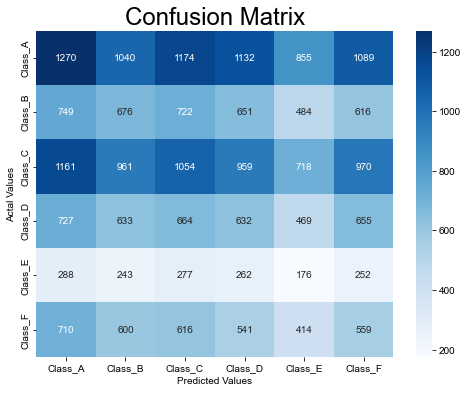

,precision,recall,f1-score,support
Class_A,0.26,0.19,0.22,6560
Class_B,0.16,0.17,0.17,3898
Class_C,0.23,0.18,0.20,5823
Class_D,0.15,0.17,0.16,3780
Class_E,0.06,0.12,0.08,1498
Class_F,0.13,0.16,0.15,3440
accuracy,0.17,0.17,0.17,0
macro avg,0.17,0.17,0.16,24999
weighted avg,0.19,0.17,0.18,24999


In [35]:
generate_performance_metrics(label_encoder.inverse_transform(y_test.Customer_category.values), 
                             label_encoder.inverse_transform(y_test_pred))

In [36]:
row_to_show = 5
data_for_prediction = X_test.iloc[row_to_show]  
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

class_probs = lgb_model.predict_proba(data_for_prediction_array)
positive_outcome = np.argmax(class_probs, axis=1)[0]

In [37]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(data_for_prediction_array)

In [38]:
shap.initjs()
shap.force_plot(explainer.expected_value[positive_outcome], 
                shap_values[positive_outcome], data_for_prediction)

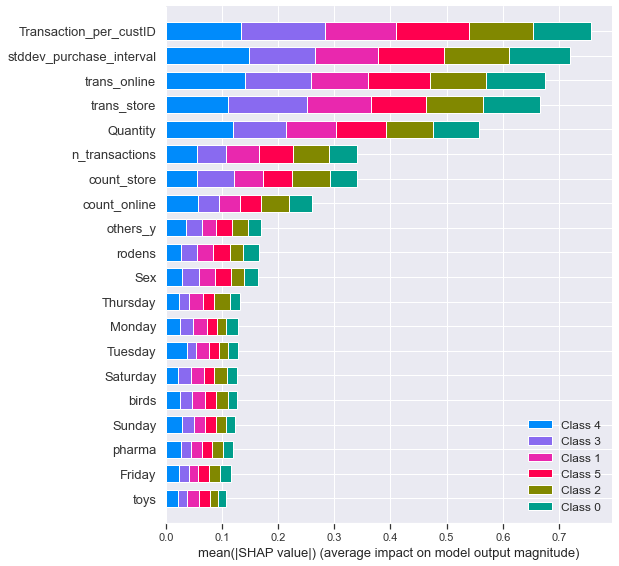

In [39]:
shap_values = explainer.shap_values(X_test.values)
shap.summary_plot(shap_values, X_test.values, feature_names = X_test.columns)

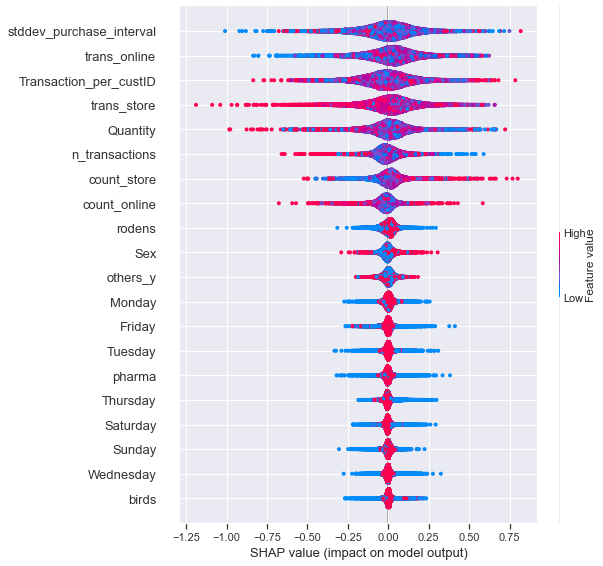

In [40]:
shap.summary_plot(shap_values[0], X_test.values, feature_names = X_test.columns)

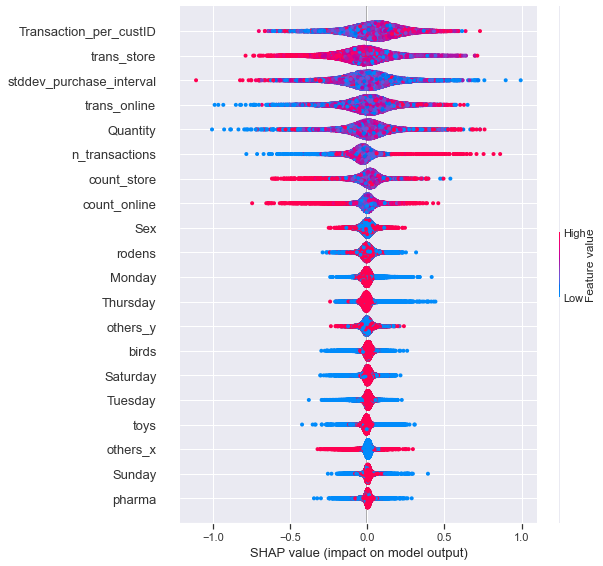

In [41]:
shap.summary_plot(shap_values[1], X_test.values, feature_names = X_test.columns)

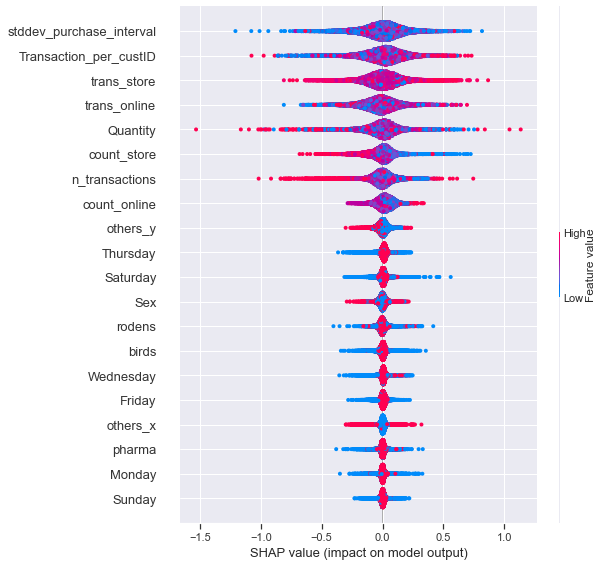

In [42]:
shap.summary_plot(shap_values[2], X_test.values, feature_names = X_test.columns)

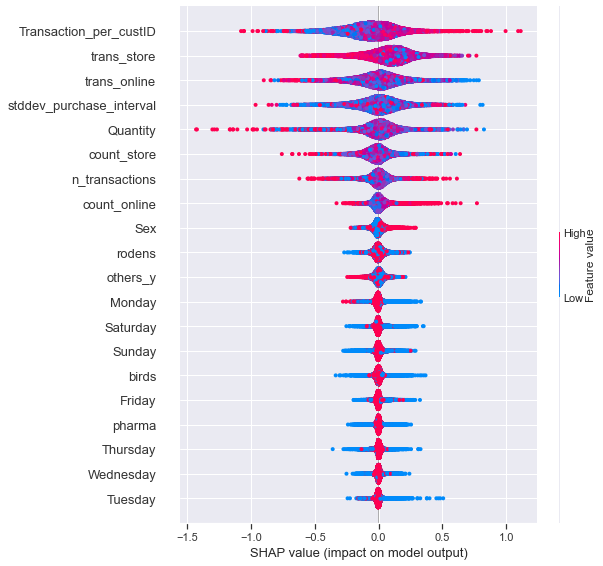

In [43]:
shap.summary_plot(shap_values[3], X_test.values, feature_names = X_test.columns)

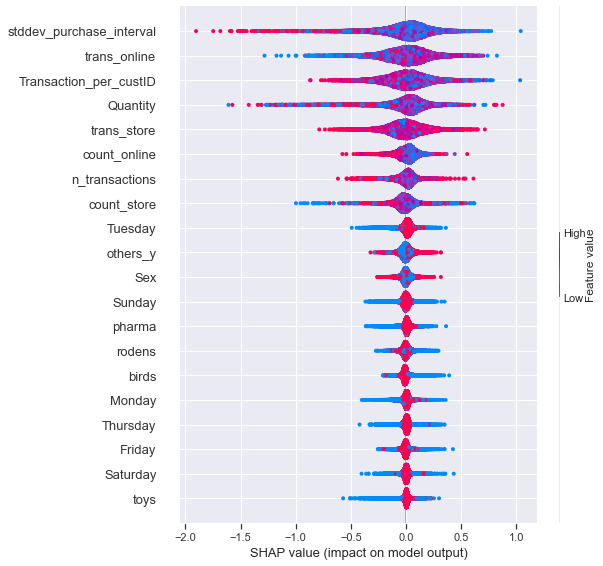

In [44]:
shap.summary_plot(shap_values[4], X_test.values, feature_names = X_test.columns)

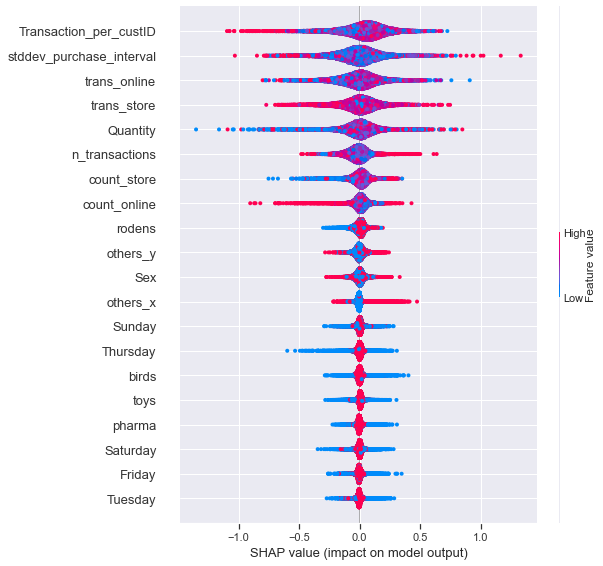

In [45]:
shap.summary_plot(shap_values[5], X_test.values, feature_names = X_test.columns)

### Modeling - Customer Segmentation - Sex

In [46]:
drop_col = 'Customer_category'
target_col = ['Sex']

In [47]:
segmentation_sex = features_customer_segment_data[['Customer_ID', 'Age']].copy()
segmentation_sex['Age'] = minmax_scaler.fit_transform(segmentation_sex[['Age']])
segmentation_sex = pd.merge(feature_transformed_df, segmentation_sex, 
                            on = 'Customer_ID', how='inner')
segmentation_sex = segmentation_sex.drop(columns=drop_col)

In [48]:
feature_corr_df = segmentation_sex.corr(method='kendall')
feature_corr_df.style.background_gradient(cmap='coolwarm')

,Customer_ID,n_transactions,Transaction_per_custID,trans_online,trans_store,count_store,count_online,food,litter,others_x,pharma,toys,birds,cats,dogs,others_y,rodens,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,stddev_purchase_interval,Quantity,Sex,Age
Customer_ID,1.000000,0.000258,0.001172,-0.000005,0.000680,0.000942,-0.002211,0.001307,0.003116,0.000406,-0.001780,0.003166,-0.002816,0.001013,0.002891,0.001199,0.002591,0.001550,0.002651,-0.000017,0.000117,0.005886,-0.001986,0.002008,0.001577,0.002085,0.002059,0.002736
n_transactions,0.000258,1.000000,0.771441,0.133799,0.609723,0.766760,0.326011,0.113289,0.179924,0.101556,0.207441,0.207923,0.203893,0.161919,0.118909,0.162373,0.197430,0.208529,0.207066,0.199861,0.207237,0.214582,0.208521,0.211917,-0.427176,0.006672,0.001505,0.000567
Transaction_per_custID,0.001172,0.771441,1.000000,0.164203,0.656620,0.645496,0.285120,0.104497,0.160212,0.090127,0.181352,0.185673,0.182404,0.143948,0.109024,0.142655,0.175371,0.184020,0.183100,0.176682,0.182932,0.191700,0.183611,0.188731,-0.367015,0.167781,0.002009,0.000531
trans_online,-0.000005,0.133799,0.164203,1.000000,-0.184258,0.025739,0.382558,0.026123,0.031161,0.017297,0.038421,0.031852,0.039607,0.030047,0.023393,0.029810,0.037232,0.039339,0.034239,0.031906,0.033757,0.039317,0.038142,0.040488,-0.069715,0.073834,-0.002881,-0.000513
trans_store,0.000680,0.609723,0.656620,-0.184258,1.000000,0.614924,0.217956,0.085949,0.134779,0.079147,0.150936,0.157385,0.151594,0.121155,0.090966,0.121203,0.148073,0.156053,0.156003,0.149750,0.154393,0.160158,0.153615,0.158238,-0.307153,0.117573,0.004098,0.001088
count_store,0.000942,0.766760,0.645496,0.025739,0.614924,1.000000,-0.005090,0.106780,0.163623,0.091110,0.188212,0.188915,0.184242,0.148429,0.113171,0.146719,0.177074,0.189156,0.186800,0.179414,0.188625,0.193890,0.188345,0.191299,-0.370845,0.003500,0.002854,0.000758
count_online,-0.002211,0.326011,0.285120,0.382558,0.217956,-0.005090,1.000000,0.055870,0.085543,0.048696,0.093956,0.096081,0.093700,0.080955,0.056422,0.073300,0.092603,0.096395,0.095778,0.094379,0.092284,0.098452,0.096308,0.098677,-0.182780,0.000159,-0.002547,0.000392
food,0.001307,0.113289,0.104497,0.026123,0.085949,0.106780,0.055870,1.000000,0.003517,-0.000153,0.002431,0.007345,0.053457,0.069984,0.065031,0.031728,0.038363,0.054632,0.047673,0.041651,0.048607,0.059395,0.057584,0.062553,-0.044906,0.005626,0.005105,0.002358
litter,0.003116,0.179924,0.160212,0.031161,0.134779,0.163623,0.085543,0.003517,1.000000,-0.000753,0.007959,0.003746,0.066523,0.061671,0.058311,0.042567,0.064397,0.072382,0.065150,0.063896,0.067426,0.066295,0.061792,0.070808,-0.089503,0.004392,-0.004118,0.000647
others_x,0.000406,0.101556,0.090127,0.017297,0.079147,0.091110,0.048696,-0.000153,-0.000753,1.000000,-0.000589,-0.000429,0.037832,0.018843,0.021816,0.015874,0.020002,0.026885,0.036905,0.031229,0.028938,0.031794,0.028732,0.027633,-0.052294,0.002395,0.001160,0.003155


In [49]:
X_data = segmentation_sex.drop(columns=target_col)
Y_data = segmentation_sex[target_col]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, 
                                                    shuffle= True, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [51]:
lgb_model = LGBMClassifier(boosting_type = 'gbdt',
                           n_estimators = 1000,
                           num_class = 1,
                           colsample_bytree = 0.6,
                           learning_rate = 0.1,
                           max_depth = 15,
                           metric = 'binary_logloss',
                           objective='binary',
                           min_child_samples = 50,
                           num_leaves = 50,
                           subsample_for_bin = 30000) 

In [52]:
lgb_model.fit(X_train.values, y_train.Sex.values)

LGBMClassifier(colsample_bytree=0.6, max_depth=15, metric='binary_logloss',
               min_child_samples=50, n_estimators=1000, num_class=1,
               num_leaves=50, objective='binary', subsample_for_bin=30000)

In [53]:
y_test_pred = lgb_model.predict(X_test.values)

Accuracy of the model = 60.7


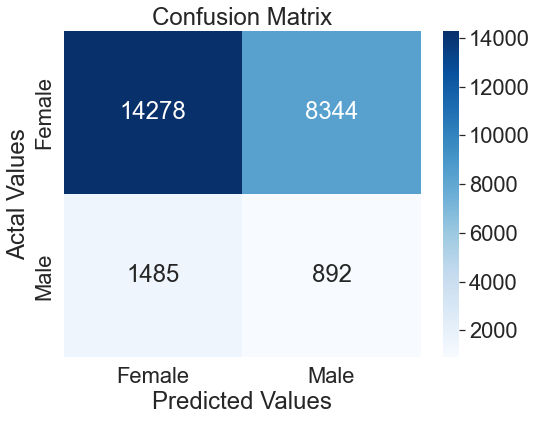

,precision,recall,f1-score,support
Female,0.91,0.63,0.74,22622
Male,0.10,0.38,0.15,2377
accuracy,0.61,0.61,0.61,0
macro avg,0.50,0.50,0.45,24999
weighted avg,0.83,0.61,0.69,24999


In [54]:
generate_performance_metrics(label_encoder_sex.inverse_transform(y_test.Sex.values), 
                             label_encoder_sex.inverse_transform(y_test_pred))

In [55]:
explainer = shap.TreeExplainer(lgb_model)

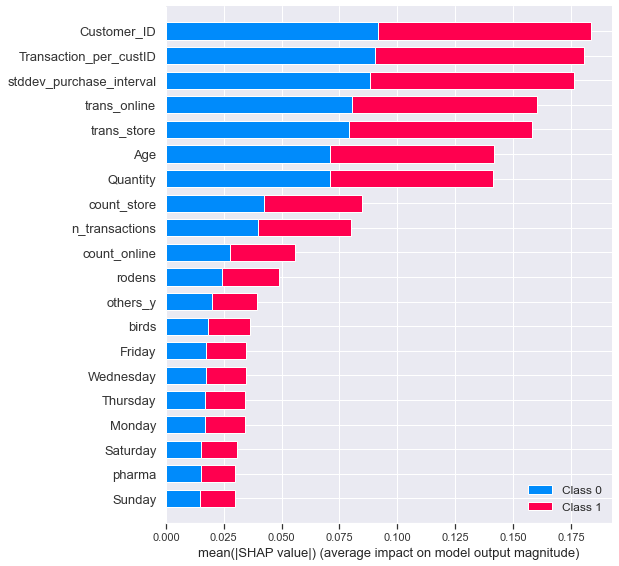

In [56]:
shap_values = explainer.shap_values(X_test.values)
shap.summary_plot(shap_values, X_test.values, feature_names = X_test.columns)

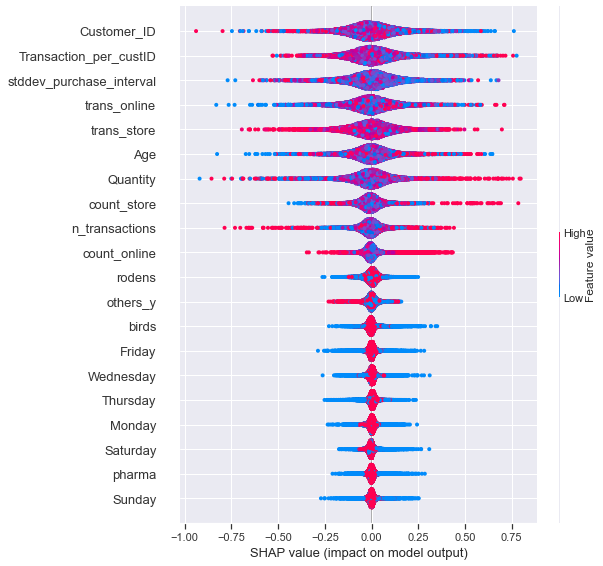

In [57]:
shap.summary_plot(shap_values[0], X_test.values, feature_names = X_test.columns)

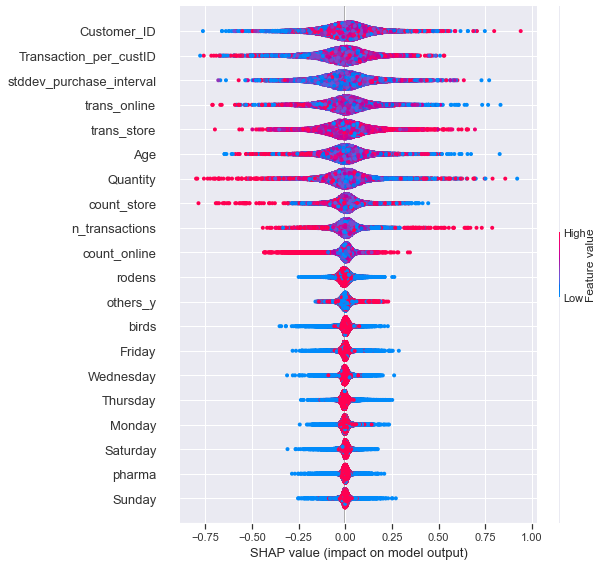

In [58]:
shap.summary_plot(shap_values[1], X_test.values, feature_names = X_test.columns)

### Modeling - Customer Segmentation - Animal 

In [106]:
feature_corr_df[['birds', 'cats', 'dogs', 'others_y']].head(10)\
                .style.background_gradient(cmap='coolwarm')

,birds,cats,dogs,others_y
Customer_ID,-0.002816,0.001013,0.002891,0.001199
n_transactions,0.203893,0.161919,0.118909,0.162373
Transaction_per_custID,0.182404,0.143948,0.109024,0.142655
trans_online,0.039607,0.030047,0.023393,0.029810
trans_store,0.151594,0.121155,0.090966,0.121203
count_store,0.184242,0.148429,0.113171,0.146719
count_online,0.093700,0.080955,0.056422,0.073300
food,0.053457,0.069984,0.065031,0.031728
litter,0.066523,0.061671,0.058311,0.042567
others_x,0.037832,0.018843,0.021816,0.015874


In [143]:
segmentation_animal_type = feature_transformation_df[['n_transactions', 'Transaction_per_custID', 
                                                      'trans_online', 'trans_store', 'count_store',
                                                      'count_online', 'food', 'litter', 'others_x',
                                                      'Customer_ID']].copy()

In [144]:
cust_to_animal = customer_segment_data.drop_duplicates(subset=['Customer_ID', 'Animal'], keep='first')
cust_to_animal = cust_to_animal[['Customer_ID', 'Animal']]

In [145]:
segmentation_animal_type = pd.merge(segmentation_animal_type, cust_to_animal, on='Customer_ID',
                                    how='inner')

In [146]:
segmentation_animal_type['Animal'].value_counts()

dogs      98813
cats      96519
birds     80226
rodens    64581
others    40312
Name: Animal, dtype: int64

In [147]:
target_col = 'Animal'
segmentation_animal_type = segmentation_animal_type.set_index('Customer_ID')
segmentation_animal_type = segmentation_animal_type.sample(frac=1)
X_data = segmentation_animal_type.drop(columns=[target_col])
Y_data = segmentation_animal_type[target_col]

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, 
                                                    shuffle= True, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [155]:
lgb_model = LGBMClassifier(boosting_type = 'gbdt',
                           n_estimators = 1000,
                           num_class = 5,
                           colsample_bytree = 0.6,
                           learning_rate = 0.1,
                           max_depth = 15,
                           metric = 'multi_logloss',
                           objective='multiclass',
                           min_child_samples = 50,
                           num_leaves = 50,
                           subsample_for_bin = 30000) 

In [160]:
lgb_model.fit(X_train.values, y_train.values, 
              )

LGBMClassifier(colsample_bytree=0.6, max_depth=15, metric='multi_logloss',
               min_child_samples=50, n_estimators=1000, num_class=5,
               num_leaves=50, objective='multiclass', subsample_for_bin=30000)

In [161]:
y_test_pred = lgb_model.predict(X_test.values)

Accuracy of the model = 12.2


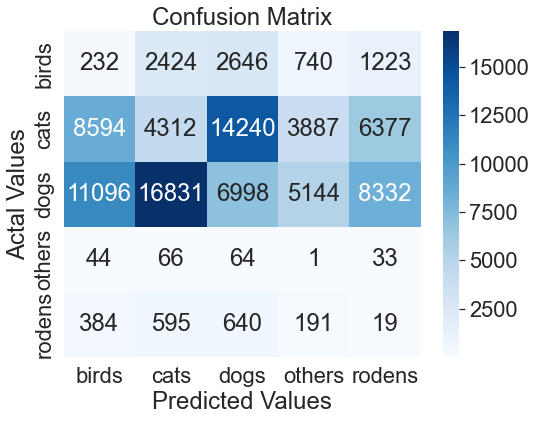

,precision,recall,f1-score,support
birds,0.01,0.03,0.02,7265
cats,0.18,0.12,0.14,37410
dogs,0.28,0.14,0.19,48401
others,0.00,0.00,0.00,208
rodens,0.00,0.01,0.00,1829
accuracy,0.12,0.12,0.12,0
macro avg,0.10,0.06,0.07,95113
weighted avg,0.22,0.12,0.15,95113


In [162]:
generate_performance_metrics(y_test.values, y_test_pred)